Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
전체 샘플 수: 676
데이터 분석 중...


Analyzing: 100%|██████████| 676/676 [03:46<00:00,  2.99it/s]
/tmp/ipython-input-3525275760.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=stats_df, x='group', ax=axes[0, 0], palette='viridis')
/tmp/ipython-input-3525275760.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='group', y='num_words', ax=axes[0, 1], palette='viridis')


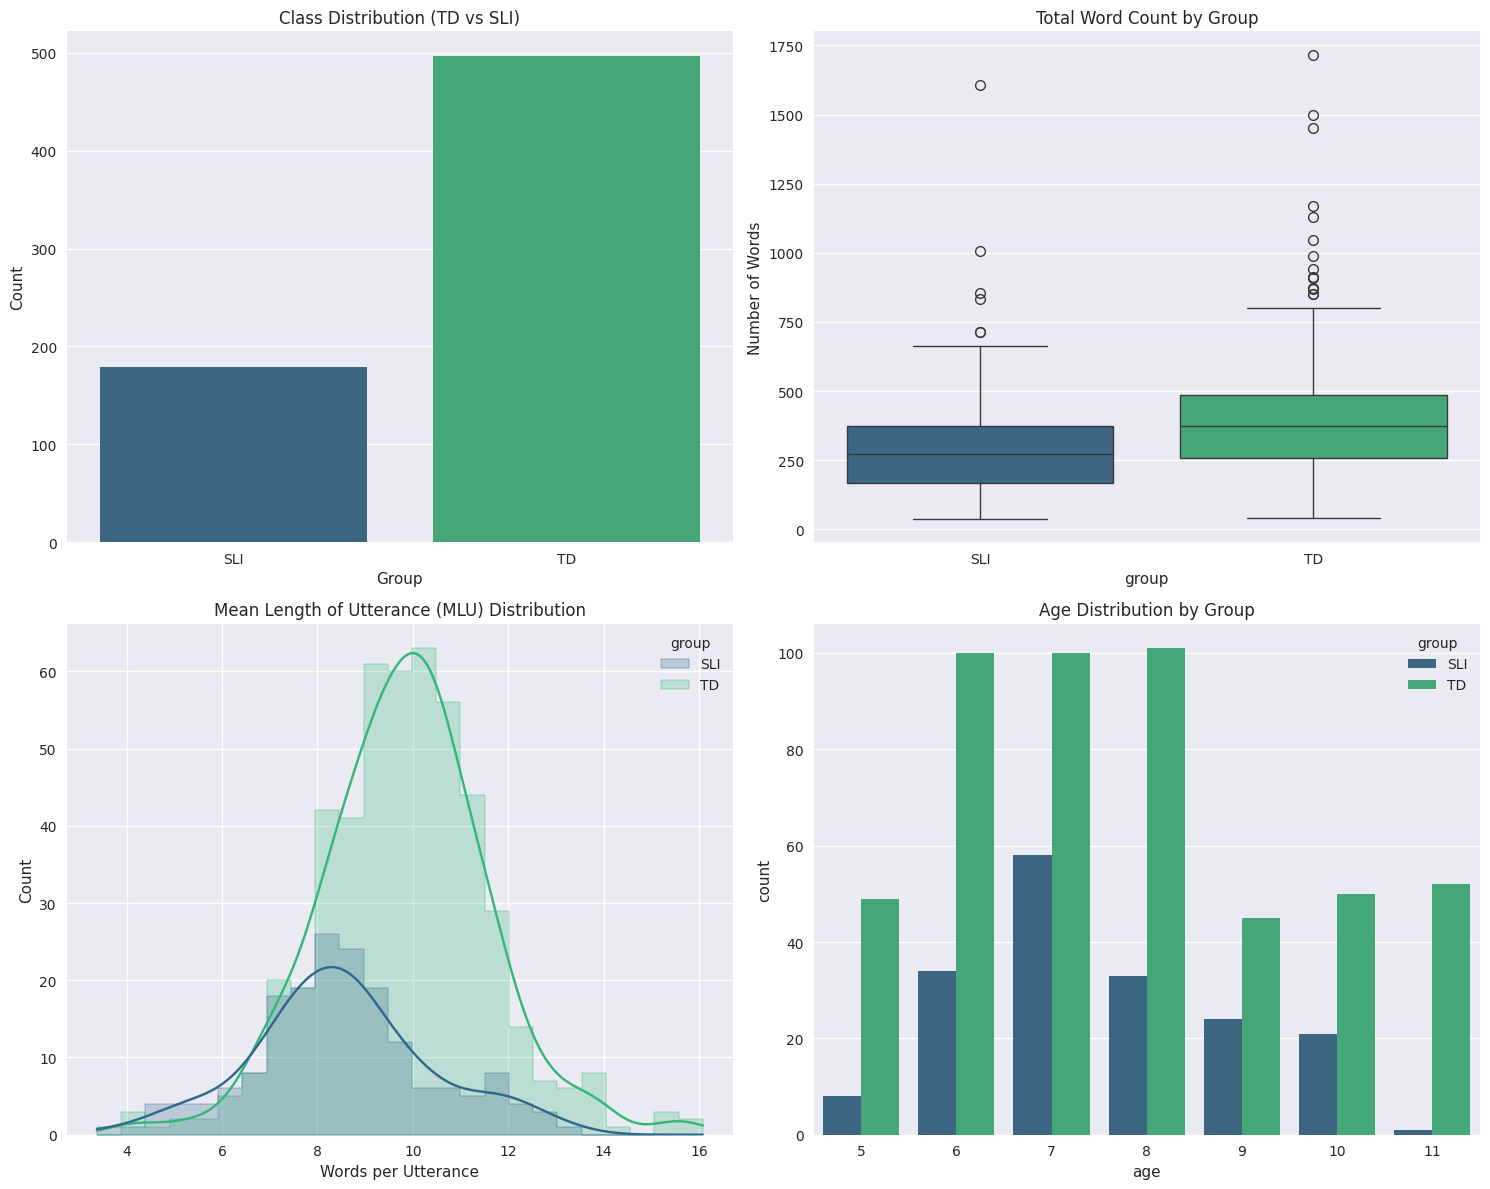


📊 어휘 분석 결과
총 고유 단어 수 (Vocab Size): 3982
가장 흔한 단어 Top 10: [('.', 24303), ('and', 17832), ('the', 11692), ('they', 7509), ('he', 7171), ('a', 6620), ('to', 5807), ('then', 4439), ('was', 4372), ('it', 2704)]

SLI 그룹 평균 단어 수: 298.10
TD 그룹 평균 단어 수: 395.50

SLI 그룹 평균 발화 길이: 8.51
TD 그룹 평균 발화 길이: 9.81


In [3]:
# ==========================================
# 1. 라이브러리 및 데이터 로드
# ==========================================
import sys
import os
from google.colab import drive

drive.mount('/content/drive')
# 본인의 경로에 맞게 수정
PROJECT_PATH = '/content/drive/MyDrive/DL_Project'
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from utils import extract_utterances
from tqdm import tqdm

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'DejaVu Sans' # 한글 폰트가 필요하면 변경

# 데이터셋 로드
train_df = pd.read_csv('split/gillam_train.csv')
dev_df = pd.read_csv('split/gillam_dev.csv')
test_df = pd.read_csv('split/gillam_test.csv')

# 전체 데이터 합치기 (전체 분포 확인용)
all_df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
print(f"전체 샘플 수: {len(all_df)}")

# ==========================================
# 2. 텍스트 통계 정보 추출 함수
# ==========================================
def get_corpus_stats(df):
    stats = []
    all_tokens = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing"):
        try:
            # 'CHI' (아동) 발화만 추출
            utts = extract_utterances(row['filename'], ['CHI'])

            # 1. 발화 개수 (Turn 수)
            num_utterances = len(utts)

            # 텍스트 전처리 및 토큰화
            full_text = " ".join([u.clean_text for u in utts]).lower()
            tokens = full_text.split()

            # 2. 총 단어 수 (Total Word Count)
            num_words = len(tokens)

            # 3. 평균 발화 길이 (MLU 근사치: Mean Length of Utterance)
            # 단어 수 / 발화 수
            mlu = num_words / num_utterances if num_utterances > 0 else 0

            stats.append({
                'group': row['group'],
                'age': row['age'],
                'gender': row['gender'],
                'num_utterances': num_utterances,
                'num_words': num_words,
                'mlu': mlu
            })
            all_tokens.extend(tokens)

        except Exception as e:
            continue

    return pd.DataFrame(stats), all_tokens

# 분석 실행 (시간이 조금 걸릴 수 있습니다)
print("데이터 분석 중...")
stats_df, all_tokens = get_corpus_stats(all_df)

# ==========================================
# 3. 시각화: 클래스 분포 및 텍스트 특징
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# [1] 클래스(Label) 분포
sns.countplot(data=stats_df, x='group', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Class Distribution (TD vs SLI)')
axes[0, 0].set_xlabel('Group')
axes[0, 0].set_ylabel('Count')

# [2] 그룹별 총 단어 수 분포 (Boxplot)
sns.boxplot(data=stats_df, x='group', y='num_words', ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Total Word Count by Group')
axes[0, 1].set_ylabel('Number of Words')

# [3] 그룹별 평균 발화 길이(MLU) 분포
sns.histplot(data=stats_df, x='mlu', hue='group', kde=True, element="step", ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Mean Length of Utterance (MLU) Distribution')
axes[1, 0].set_xlabel('Words per Utterance')

# [4] 연령별 샘플 수 확인
sns.countplot(data=stats_df, x='age', hue='group', ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Age Distribution by Group')

plt.tight_layout()
plt.show()

# ==========================================
# 4. 어휘 분석 (Top Frequent Words)
# ==========================================
print("\n" + "="*40)
print("📊 어휘 분석 결과")
print("="*40)

# 전체 단어 빈도
vocab_counts = Counter(all_tokens)
print(f"총 고유 단어 수 (Vocab Size): {len(vocab_counts)}")
print(f"가장 흔한 단어 Top 10: {vocab_counts.most_common(10)}")

# 그룹별 Top 단어 비교
sli_df = stats_df[stats_df['group'] == 'SLI']
td_df = stats_df[stats_df['group'] == 'TD']

print(f"\nSLI 그룹 평균 단어 수: {sli_df['num_words'].mean():.2f}")
print(f"TD 그룹 평균 단어 수: {td_df['num_words'].mean():.2f}")

print(f"\nSLI 그룹 평균 발화 길이: {sli_df['mlu'].mean():.2f}")
print(f"TD 그룹 평균 발화 길이: {td_df['mlu'].mean():.2f}")